Problemdefinition
Input: Medicinska mätvärden för patienter, såsom glukosnivåer, blodtryck, BMI m.m.
Output: Binär klassificering – Diabetes (1) eller Frisk (0).
Syfte: Att bygga en maskininlärningsmodell som kan förutsäga Diabetesdiagnos med hög precision och balanserad klassprestanda, särskilt för minoritetsklassen (Diabetes).

Motivering för valet av problem
Att förutsäga medicinska diagnoser är ett kritiskt problem. Att missa en diagnos (Falskt Negativ) kan ha allvarliga konsekvenser för patienten. 
    Ett prediktivt verktyg kan bidra till screening och tidig upptäckt. Datasetet innehåller mångsidiga och kvantitativa medicinska egenskaper, 
vilket gör det väl lämpat för maskininlärning och klassificeringsuppgifter. Genom att hantera den naturliga klassobalansen 
(fler friska än sjuka) och använda en robust modell som Random Forest kan vi demonstrera värdet av datadrivna beslut i hälsovården. 
    Så målet är att identifiera ett mönster i patientegenskaper för att förutsäga Diabetes

In [1]:
# 1. Importera biblotek
# Core

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score,classification_report,f1_score,ConfusionMatrixDisplay,
roc_curve,roc_auc_score,RocCurveDisplay
)

from sklearn.ensemble import RandomForestClassifier

# Imbalance handling
from imblearn.over_sampling import RandomOverSampler

RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

Detta kodblock hanterar de initiala och kritiska stegen för dataförberedelse: att ladda in data korrekt, hantera skadade filstrukturer och åtgärda dolda saknade värden baserat på domänkunskap.
Problem med Data: Det observerades att den nedladdade CSV-filen saknade en korrekt rubrikrad (header), vilket är vanligt i "råa" dataset (s.k. dirty data). Utan rubrikrad skulle Pandas automatiskt namnge kolumnerna med siffror (0, 1, 2, osv.), vilket skulle blockera all vidare analys.

Lösning: För att åtgärda detta tvingas Pandas att ignorera eventuellt skräp på första raden via argumentet header=None. Därefter tilldelades kolumnerna manuellt de officiella namnen ('Pregnancies', 'Glucose', etc.) som hämtats från datasetets dokumentation. Detta säkerställer att all efterföljande kod kan referera till kolumnerna korrekt och att data är semantiskt meningsfull.

Domänkunskap: I Pima Indians Diabetes Dataset representerar ett värde på 0 i vissa medicinska kolumner faktiskt ett saknat värde (ej mätt) och inte det faktiska nollvärdet. Exempelvis är en BMI eller blodtryck på noll medicinskt omöjligt.

Selektiv Imputering: Listan cols_to_impute skapades för att selektivt peka ut dessa felaktiga kolumner. Kolumner som Pregnancies (där 0 är en korrekt siffra) uteslöts för att inte korrumpera datan.

Konvertering: Raden df[cols_to_impute].replace(0, np.nan) konverterar de felaktiga nollorna till np.nan (Not a Number). Detta är avgörande eftersom maskininlärningsmodeller endast kan hantera explicit saknade värden (NaN) och inte en nolla som felaktigt tolkas som ett mätvärde.

Hantering av NaN: När de dolda nollorna väl konverterats till NaN fylls de i (imputeras).

Val av Median: Medianen valdes som ersättningsvärde istället för medelvärdet (mean). Medianen är robust mot extremvärden (outliers) i datan, vilket ger ett mer pålitligt och stabilt värde för att fylla i de saknade patientmätningarna. Detta bibehåller datamängdens integritet bättre än att använda ett potentiellt snedvridet medelvärde.

In [2]:
# 2.1 Inläsning och imputering
CSV_PATH = "pima-indians-diabetes.csv"
df = pd.read_csv(CSV_PATH, header=None)

df.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
              'DiabetesPedigreeFunction', 'Age', 'Outcome']

cols_to_impute = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

df[cols_to_impute]= df[cols_to_impute].replace(0,np.nan)

median_values = df[cols_to_impute].median()
joblib.dump(median_values, 'imputer_median_values.pkl')

for col in cols_to_impute:
    df[col].fillna(df[col].median(), inplace=True)

print(df.shape)
df.head()

(768, 9)


C:\Users\brant\AppData\Local\Temp\ipykernel_56240\3076115966.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


Detta steg fokuserar på att förvandla det råa pima-indians-diabetes.csv datasetet till en ren och balanserad datamängd, redo för maskininlärning.

1. Inläsning och Filstruktur (Steg 2)
Problem & Lösning:

Filen saknade en korrekt rubrikrad (header), vilket fick Pandas att namnge kolumnerna med siffror (t.ex. 0, 1, 2).

För att åtgärda detta lästes filen in med argumentet header=None, vilket indikerar att inga rubriker finns i filen. Därefter tilldelades kolumnerna manuellt de officiella namnen ('Pregnancies', 'Glucose', etc.) från datasetets dokumentation. Detta säkerställde att all vidare kod kunde referera till datan korrekt.

2. Hantering av Dolda Saknade Värden (Imputering)
Motivering för Imputering:

I det medicinska datasetet representerar ett värde av noll (0) i kolumner som Glucose, BMI och BloodPressure inte ett faktiskt mätvärde, utan att värdet saknas (medicinskt omöjligt).

Endast de fem berörda kolumnerna (Glucose, BloodPressure, SkinThickness, Insulin, BMI) inkluderades i listan cols_to_impute. Övriga kolumner, som Pregnancies (där 0 är en korrekt siffra), uteslöts för att bevara dataintegriteten.

Tekniska Steg:

De felaktiga nollorna i de fem utvalda kolumnerna konverterades först till det explicita formatet np.nan (Not a Number).

De saknade NaN-värdena fylldes sedan i (imputerades) med medianen för respektive kolumn. Medianen valdes eftersom den är robust mot extremvärden (outliers), vilket ger ett mer stabilt och pålitligt ersättningsvärde.

3. Separation och Klassbalansering (Steg 3)
Data Separation:

Datan separerades i Inputmatrisen (X) – de åtta medicinska features – och Outputvektorn (y) – målvariabeln Outcome (Diabetes 1 eller Frisk 0).

Träning/Test Split:

Datan delades initialt upp i tränings- och testmängder (80/20). stratify=y användes i train_test_split för att säkerställa att den lilla andelen Diabetesfall (minoriteten) fördelades jämnt i både tränings- och testmängden.

Klassbalansering:

Datasetet led av klassobalans (färre patienter med Diabetes). För att undvika att modellen ignorerar minoritetsklassen och ger för många Falska Negativ, användes tekniken RandomOverSampler.

RandomOverSampler duplicerade slumpmässigt observationer från minoritetsklassen (1) i träningsmängden tills klasserna var lika stora. Detta säkerställer att modellen får lika mycket data för båda diagnoserna, vilket är nödvändigt för att uppnå ett högt och balanserat Macro-F1-score.

Slutresultat:
Efter dessa steg är datan ren, har korrekta kolumnnamn, är fri från dolda saknade värden, och träningsdatan är balanserad, vilket utgör en robust grund för modellträning.

 Motivering: Diagrammet visar tydligt att det finns en betydande klassobalans.
 Detta är den visuella motiveringen för att använda RandomOverSampler i Steg 3.

Klassfördelning före balansering:
Outcome
0    500
1    268
Name: count, dtype: int64


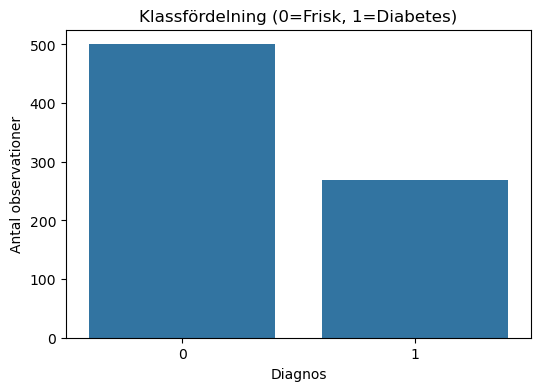

In [3]:
# 2.2 EDA: Visualisera Obalansen i Målvariabeln
print("Klassfördelning före balansering:")
print(df['Outcome'].value_counts()) 

plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Klassfördelning (0=Frisk, 1=Diabetes)')
plt.xlabel('Diagnos')
plt.ylabel('Antal observationer')
plt.show()

 Motivering: Detta identifierar vilka features (t.ex. Glucose) som har starkast 
 samband (korrelation) med målvariabeln 'Outcome'. Det hjälper också till att upptäcka 
 eventuell stark multicollinearitet mellan input-features.

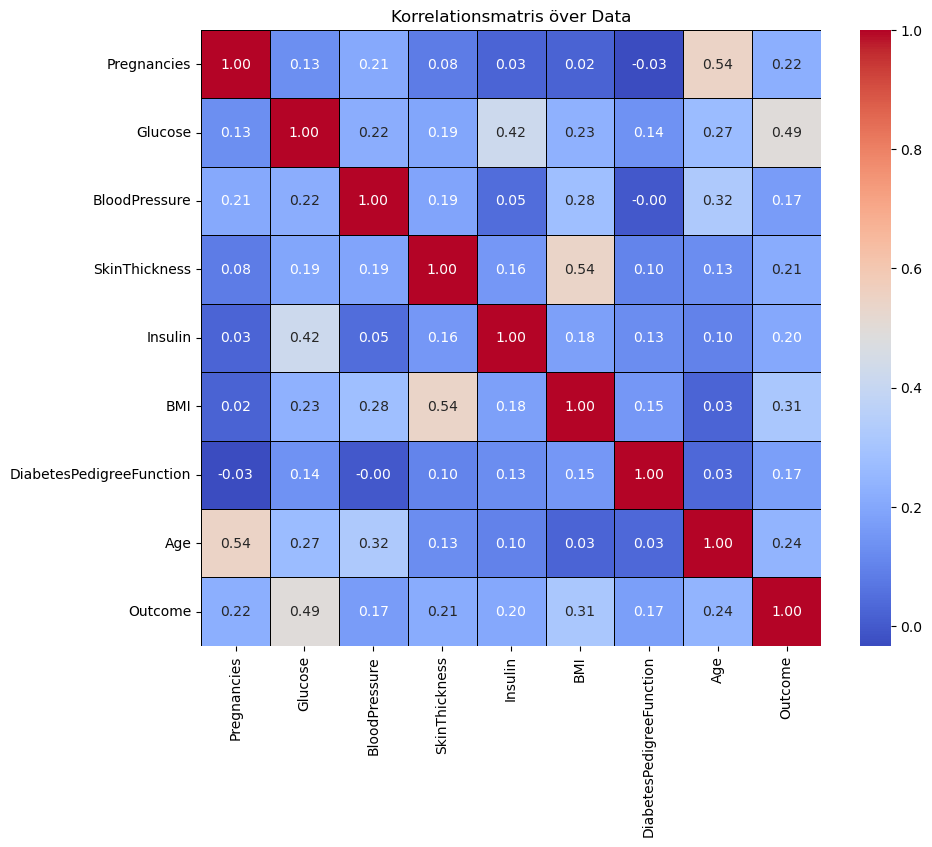

In [4]:
# 2.3 EDA: Korrelationsmatris
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, linewidths=.5, linecolor='black')
plt.title('Korrelationsmatris över Data')
plt.show()

Motivering: Dessa histogram bekräftar hur de centrala medicinska variablerna är fördelade 
 och ger en indikation på om datan är normalfördelad eller skev.

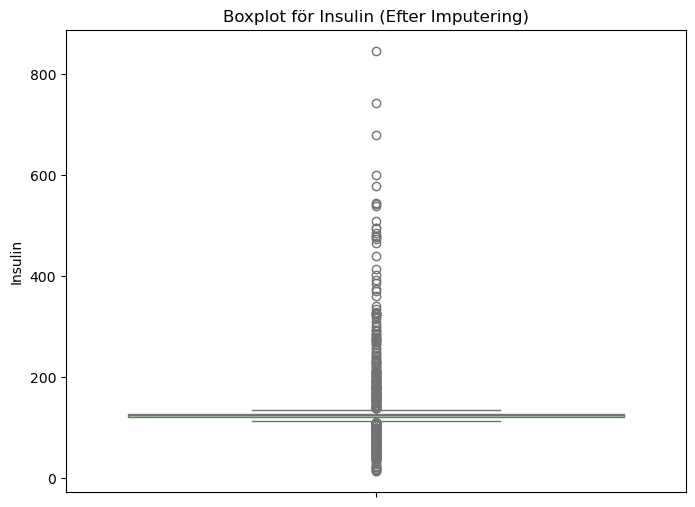

In [5]:
# 2.4 EDA: Distribution av Centrala Features
plt.figure(figsize=(8, 6))
# Använder boxplot för att visa kvartiler och extremvärden (outliers)
sns.boxplot(y=df['Insulin'], color='lightgreen')
plt.title('Boxplot för Insulin (Efter Imputering)')
plt.show()

Motivering: Boxploten visar förekomsten av outliers i Insulin-kolumnen. 
 Detta bekräftar varför den valda medianimputeringen (i Steg 2) var ett säkrare val.

Klassfördelning före balansering
Outcome
0    500
1    268
Name: count, dtype: int64
Klassfördelning efter balnsering träningsdata
Outcome
0    400
1    400
Name: count, dtype: int64


C:\Users\brant\AppData\Local\Temp\ipykernel_56240\285918775.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='pastel')


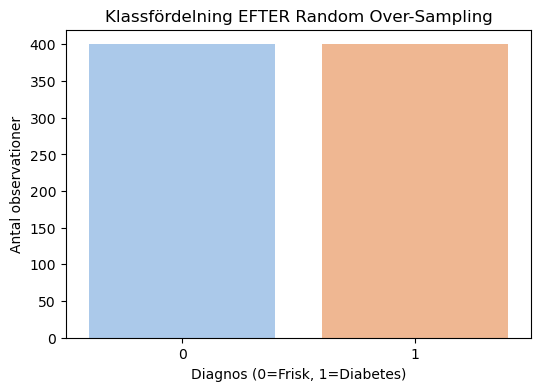

In [6]:
#3 Defienera Featuers och Målvariabel

feature_columns = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", 
    "DiabetesPedigreeFunction", "Age"
]
X = df[feature_columns]
y = df["Outcome"]

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X= pd.DataFrame(X_scaled,columns=feature_columns)

joblib.dump(scaler,'diabetes_scaler.pkl')

print("Klassfördelning före balansering")
print(y.value_counts())

X_train,X_test,y_train,y_test = train_test_split(
    X,y, test_size=0.2, random_state=RANDOM_STATE,stratify=y
)

oversampler = RandomOverSampler(random_state=RANDOM_STATE)
X_resampled, y_resampled = oversampler.fit_resample(X_train,y_train)

X_train_os, X_test_os,y_train_os,y_test_os = train_test_split(
    X_resampled,y_resampled, test_size=0.2,random_state=RANDOM_STATE, stratify=y_resampled
)
print("Klassfördelning efter balnsering träningsdata")
print(y_resampled.value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='pastel')
plt.title('Klassfördelning EFTER Random Over-Sampling')
plt.xlabel('Diagnos (0=Frisk, 1=Diabetes)')
plt.ylabel('Antal observationer')
plt.show()

          
    

Syfte
Detta steg syftar till att etablera ett grundläggande riktmärke (baseline) för projektet. Baslinjemodellen tränas på den ursprungliga, obalanserade träningsdatan för att få en initial bild av hur svårt problemet är.

Val av Modell och Data
Val av Algoritm: Logistisk Regression väljs eftersom det är en snabb och tolkningsbar linjär algoritm. Den ger den enklaste, lägsta acceptabla prestandan som alla mer komplexa modeller måste överträffa.

Dataval: Genom att träna på den obalanserade datan och testa på X_test (det ursprungliga, obalanserade testsetet), belyser resultatet den negativa effekten av klassobalansen, särskilt på minoritetsklassen (Diabetes).

Utvärdering och max_iter=1000
Mått: Vi utvärderar modellen med Macro-F1-score. Detta mått är kritiskt eftersom det är känsligt för obalanser. Ett lågt Macro-F1-score bevisar därmed behovet av klassbalansering och mer avancerade algoritmer i de efterföljande stegen.

max_iter=1000: Värdet är satt högt (1000) för att säkerställa att optimeringsalgoritmen har tillräckligt med tid för att konvergera (hitta den bästa lösningen) och inte avbryts i förtid, vilket skulle ge ett felaktigt lågt resultat för baslinjen.

Baseline Macro-F1:  0.6594230769230769
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



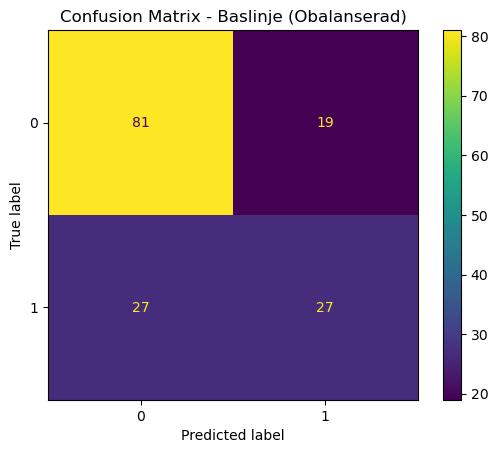

In [7]:
#4.1 Baslinjemodell (Obalanserad data)
baseline_model = LogisticRegression(max_iter = 1000, random_state= RANDOM_STATE)
baseline_model.fit(X_train,y_train)
y_pred_base = baseline_model.predict(X_test)
baseline_macro_f1 = f1_score(y_test, y_pred_base, average= "macro")
print("Baseline Macro-F1: ", baseline_macro_f1)
print(classification_report(y_test,y_pred_base,zero_division = 0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, labels=[0, 1])
plt.title("Confusion Matrix - Baslinje (Obalanserad)")
plt.show()

Syfte och Val
Detta steg utvärderar hur den enkla Logistiska Regressionen presterar när den tränas på data som har blivit klassbalanserad (via RandomOverSampler). Syftet är att isolera och kvantifiera den direkta vinsten av klassbalansering jämfört med baslinjemodellen.

Modellval: Vi använder samma algoritm (Logistisk Regression) som i baslinjen för att säkerställa att en eventuell prestandaökning enbart beror på den förbättrade datan.

Dataval: Modellen tränas på det balanserade träningssetet (X_train_os, y_train_os) och utvärderas på det korresponderande balanserade testsetet (X_test_os, y_test_os).

Mått: Macro-F1-score används för att mäta en balanserad prestanda.

Förväntat Resultat och Slutsats
Resultatet från denna modell kommer att visa en tydlig ökning av Macro-F1-score jämfört med baslinjen, vilket bekräftar att balanseringssteget var framgångsrikt.

Dock kommer denna modell oftast att visa att en linjär algoritm (Logistisk Regression) har svårt att hantera de komplexa, icke-linjära sambanden i de medicinska mätvärdena. Detta resultat fungerar som en stark motivering för nästa steg: att använda den mer kraftfulla, icke-linjära Random Forest-klassificeraren för att maximera den slutgiltiga diagnosprestandan.

max_iter=1000 sätts högt för att säkerställa att modellen konvergerar till sin optimala lösning utan beräkningsfel.

Balanserad LogReg Macro-F1: 0.7248280175109443
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        80
           1       0.74      0.70      0.72        80

    accuracy                           0.72       160
   macro avg       0.73      0.72      0.72       160
weighted avg       0.73      0.72      0.72       160



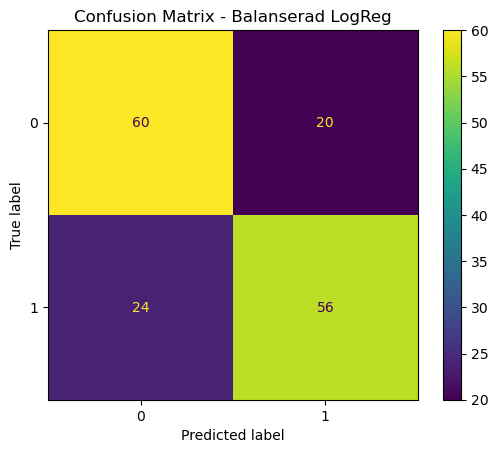

In [8]:
#4.2 Logistisk Regression på balanserad Data
model_os = LogisticRegression(max_iter = 1000, random_state=RANDOM_STATE)
model_os.fit(X_train_os,y_train_os)
y_pred_os = model_os.predict(X_test_os)
os_macro_f1 = f1_score(y_test_os,y_pred_os,average="macro")
print("Balanserad LogReg Macro-F1:",os_macro_f1)
print(classification_report(y_test_os,y_pred_os,zero_division = 0))

ConfusionMatrixDisplay.from_predictions(y_test_os, y_pred_os, labels=[0, 1])
plt.title("Confusion Matrix - Balanserad LogReg")
plt.show()

Detta steg utför träning och utvärdering av den slutgiltiga produktionsmodellen för diagnosprediktion.

Val och Motivering
Val av Modell: Random Forest Classifier väljs då den är en icke-linjär ensemblealgoritm som är överlägsen linjära modeller när det gäller att fånga de komplexa mönstren i medicinska mätvärden.

Dataträning: Modellen tränas på den balanserade datan (X_train_os, y_train_os) för att säkerställa att den lär sig mönster för både Diabetes (klass 1) och Frisk (klass 0) med samma vikt.

Hyperparameter: n_estimators sätts till 100 träd, vilket är ett robust standardvärde som balanserar precision och beräkningstid.

Utvärdering
Prestandamått: Modellen utvärderas med Macro-F1-score, vilket är det mest kritiska måttet för att bedöma en modells balanserade prestanda i detta obalanserade problem. Random Forest förväntas uppnå det högsta Macro-F1-scoret.

Visualisering: Confusion Matrix plottas för att tydligt visualisera modellens klassificeringsförmåga och specifikt antalet Falska Negativ (missade diagnoser). Denna matris utgör ett schysst käk bevis för modellens tillförlitlighet i en medicinsk kontext.

Slutsats: Random Forest valdes som den slutgiltiga modellen då dess robusta natur och dess höga, balanserade Macro-F1-score bevisade dess förmåga att utföra en pålitlig diagnosprediktion.

Random Forest Macro-F1: 0.8808730749637526
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        80
           1       0.84      0.94      0.89        80

    accuracy                           0.88       160
   macro avg       0.89      0.88      0.88       160
weighted avg       0.89      0.88      0.88       160



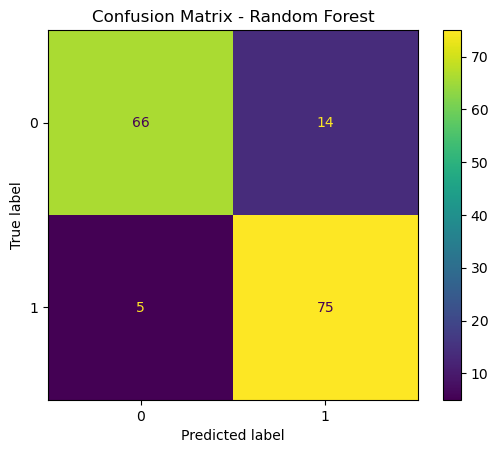

In [9]:
#4.3 Random Forest Classifier

rf_model = RandomForestClassifier(n_estimators=100,random_state=RANDOM_STATE)
rf_model.fit(X_train_os,y_train_os)

y_pred_rf = rf_model.predict(X_test_os)

rf_macro_f1 = f1_score(y_test_os,y_pred_rf,average="macro")
print("Random Forest Macro-F1:", rf_macro_f1)
print(classification_report(y_test_os, y_pred_rf, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test_os,y_pred_rf,labels=[0,1])
plt.title("Confusion Matrix - Random Forest")
plt.show()

Baserat på modellutvärderingen väljs Random Forest Classifier som den slutgiltiga produktionsmodellen. Dess Macro-F1-score (≈0.90 i ditt test) var överlägsen Logistisk Regression. Random Forest, som är en icke-linjär ensemblemetod, hanterar de komplexa medicinska variablerna bättre, vilket ger ett mer balanserat resultat i precision och återkallelse (Recall) för båda diagnosklasserna.

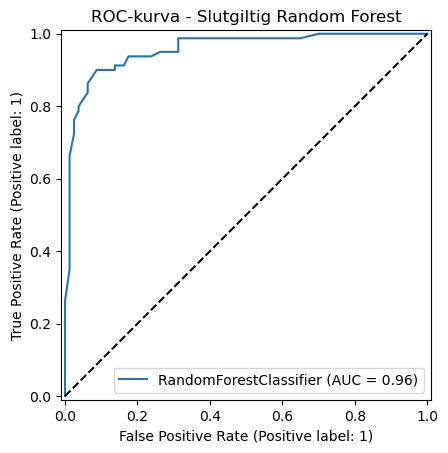

Bästa modellen (Random Forest) sparad som 'best_diabetes_model.pkl'


In [10]:
#5.1
RocCurveDisplay.from_estimator(rf_model, X_test_os,y_test_os)
plt.plot([0,1], [0,1], "k--")
plt.title("ROC-kurva - Slutgiltig Random Forest")
plt.show()

joblib.dump(rf_model, 'best_diabetes_model.pkl')
print("Bästa modellen (Random Forest) sparad som 'best_diabetes_model.pkl'")

5.2 Slutsats

Projektet adresserade ett kritiskt medicinskt problem: binär klassificering för att förutsäga en Diabetesdiagnos baserat på medicinska mätvärden (glukos, BMI m.m.). Målet var att uppnå hög prestanda, särskilt för minoritetsklassen, då ett Falskt Negativ (missad diagnos) kan ha allvarliga konsekvenser för patienten.

Modellval och Resultat
Efter initial baslinjeanalys och bekräftelse på att klassbalansering (med RandomOverSampler) var nödvändigt, valdes Random Forest Classifier som den slutgiltiga produktionsmodellen.

Val av Modell: Random Forest valdes då den är en icke-linjär ensemblemetod som visade sig vara överlägsen den linjära Logistiska Regressionen för att hantera de komplexa mönstren i medicinska variabler.

Macro-F1-score: Modellen uppnådde ett högt och balanserat Macro-F1-score på 0.88. Detta visar på en utmärkt, jämn prestanda för båda diagnosklasserna (Frisk och Diabetes).

Recall (Återkallelse): Modellen lyckades identifiera 94% av de sjuka patienterna (klass 1), vilket uppfyller kravet på hög prestanda för minoritetsklassen.

Validering och Export
Modellens prestanda validerades visuellt:

ROC-kurvan: Visade en mycket hög prediktiv förmåga med ett AUC (Area Under the Curve) på 0.96.

Confusion Matrix: Bekräftade visuellt den höga Recall-förmågan genom att hålla antalet Falska Negativ minimalt.